## Machine learning algorithms and optimization
- cost function
- linear regression

### Lets first consider Linear regression
- $h(\theta) = \frac{1}{m}\sum_{i} (\theta^T x^i-y^i)^2 =  \frac{1}{m} (\theta^T X^T - Y^T)(X \theta - Y)$
- here $Y=(y^1,y^2,\dots,y^m)^T$, $X=(x^1,x^2,\dots,x^m)^T$, and $\theta^T=(\theta_0,\theta_1,\dots,\theta_n)$, $n$ being the number of features, and $m$ being the number of training sets.
- One-batch minimization gives: $\theta = (X^TX)^{-1}X^TY$
- remember to add a biase $\theta_0$.
- the LinearRegression class has an implication based on SVD (pseudoinverse)
- Online learning and Gradient Descent

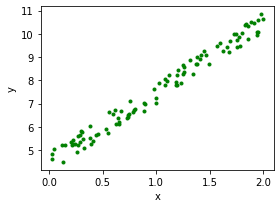

In [11]:
import numpy as np
import matplotlib.pyplot as plt 

# 100 samples and 1 feature
X = 2 * np.random.rand(100,1)
Y = 4 + 3 * X + np.random.rand(100,1)

fig = plt.figure(figsize=(4,3))
plt.plot(X,Y,"g.")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [20]:
Xb = np.c_[np.ones((100,1)),X]
theta_best = np.dot(np.linalg.inv(np.dot(Xb.T,Xb)),np.dot(Xb.T,Y))
print(theta_best)

[[4.4984886 ]
 [3.02700929]]


In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,Y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(np.array([[0],[4],[6]])))

[4.4984886] [[3.02700929]]
[[ 4.4984886 ]
 [16.60652575]
 [22.66054433]]


### Gradient Descent
- partial derivative of the cost function with respect to any parameter $\theta_j$ is: $\nabla_\theta h(\theta) = \frac{2}{m}X^T(X\theta - Y)$
- Gradient Descent step: $\theta_{i+1} = \theta_{i} - \eta \nabla_{\theta}h(\theta)|_{\theta_i}$
- No need to compute matrix inverse or pseudoinverse
- batch gradient descent is computationally costly, use stochastic gradient descent! this is very similar to the Metropolis algorithm of local updates in physics (MC simulations)

In [29]:
eta = 0.1 
n_iter = 1000
m = 100
theta = np.random.rand(2,1) 

for itr in range(n_iter):
    gradients = 2/m * (np.dot(Xb.T,np.dot(Xb,theta)- Y) )
    theta = theta - eta * gradients
    
print(theta)

[[4.4984886 ]
 [3.02700929]]


In [32]:
# stochastic gradient descent 
n_epochs = 50
t0, t1 = 4, 50 

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.rand(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = Xb[random_index:random_index+1,:]
        yi = Y[random_index:random_index+1]
        gradients = 2 * np.dot(xi.T,np.dot(xi,theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
print(theta)

[[4.4796295 ]
 [3.02713985]]


In [40]:
# sklearn SGD
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3,penalty=None,eta0=0.1)
sgd_reg.fit(X,Y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.47307049] [3.02345102]


### Polynomial regression
- this can be implemnted using linear regression, by treating higher order polynomials of certain features as new features 

In [41]:
m = 100
X = 6 * np.random.rand(m,1) - 3
Y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-2.71591998]
[-2.71591998  7.37622132]


In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,Y)
lin_reg.intercept_, lin_reg.coef_

(array([1.81786582]), array([[0.95528711, 0.52933038]]))

In [51]:
sgd_reg = SGDRegressor(max_iter=2000, tol=1e-3,penalty=None,eta0=0.1)
sgd_reg.fit(X_poly,Y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)


[1.84882267] [0.97222829 0.45046233]


## Plot learning curves
- how any function changes over SG learning 

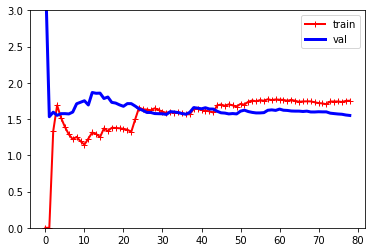

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
    plt.plot(np.sqrt(train_errors),"r-+",lw=2,label="train")
    plt.plot(np.sqrt(val_errors),"b-",lw=3,label="val")
    plt.ylim([0,3])
    plt.legend()
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,Y)

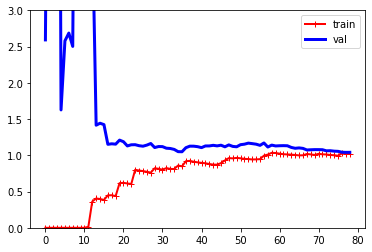

In [59]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression()),
])
plot_learning_curves(polynomial_regression,X,Y)

## Let's consider logistic regression next
- binary classifier 
- estimating probabilities: activation function, sigmoid $\hat{p}\equiv h_\theta(x) = \sigma(x^T\theta)$
- cost function for training: $J(\theta) = -\frac{1}{m}\sum_{i}\left[ y^i\log(\hat{p}^i) +(1-y^{i})\log(1-\hat{p}^i)\right]$
- $\partial_{\theta_j}J(\theta) = \frac{1}{m}\sum_{i} (\sigma(\theta^Tx^i)-y^i)x_j^{i}$

In [60]:
## test out on iris data set
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [67]:
X = iris["data"][:,3:]  # pedal width
y = (iris["target"]==2).astype(np.int) # virginica or not 

In [68]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

## Softmax function

- train a parameter vector $\theta^{(k)}$ for every class to be classified (using sigmoid binary classifier, logistic regression)
- define score as $s_k(x) = x^T\theta^{(k)}$
- probability of the $k$-th class is given by $\hat{p}_k = \frac{\exp(s_k(x)}{\sum_{k}\exp(s_k(x))}$  (softmax regression)
- quite analogous to the partition function in physics
- cross entropy cost function: $J(\Theta) = - \frac{1}{m}\sum_i \sum_{k} y_k^{(i)}\log(\hat{p}_{k}^{(i)})$
- gradient vector for class k: $\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m}\sum_{i} (p_k^{(i)}-y_k^{(i)})x^{(i)}$.
- optimizing the cross entropy cost function trains a multi-class classifier in one shot
- mutually exclusive classes necessary

In [70]:
X = iris["data"][:,(2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')